In [106]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [107]:
import numpy as np
import pandas as pd

In [108]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [109]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [110]:
# create engine
engine = create_engine("sqlite:///hawaii.sqlite", echo = False)
conn = engine.connect()

In [111]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [112]:
# get table names

inspector = inspect(engine)
inspect(engine).get_table_names()

['measurement', 'station']

In [113]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [114]:
# Create our session (link) from Python to the DB

session = Session(bind=engine)

# Explore Data before Analyzing

In [115]:
# print columns names and types for 'measurement'
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [116]:
# print columns names and types for 'station'
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [117]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [118]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [131]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# columns to select
sel_measure = [Measurement.id,
       Measurement.station,
       Measurement.date,
       Measurement.prcp,
       Measurement.tobs]

prev_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# query
measurement_result = session.query(*sel_measure).\
    filter(Measurement.date >= prev_date).all()

In [132]:
# Plot the Results in a Matplotlib bar chart

# create Pandas df
mdf = pd.DataFrame(measurement_result, columns = ['id', 'station','date', 'prcp', 'tobs'])

# sort values by date ascending
mdf.sort_values(by='date', inplace=True)

# subset df to include only date and precipitation
mdf_plot = mdf[['date', 'prcp']]

# set date as index
mdf_plot.set_index('date', inplace=True)

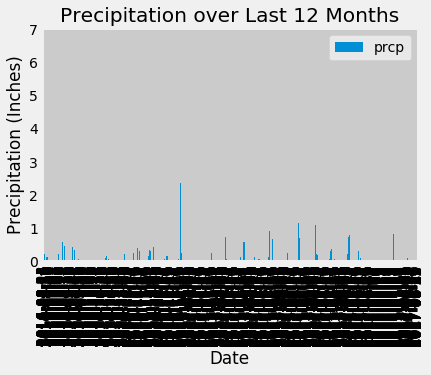

In [141]:
# plot precipitation
mdf_plot.plot.bar()
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.title(f'Precipitation over Last 12 Months')

plt.show()

In [137]:
# Use Pandas to calcualte the summary statistics for the precipitation data

mdf_plot.describe().round(3)

,prcp
count,2021.000
mean,0.177
std,0.461
min,0.000
25%,0.000
50%,0.020
75%,0.130
max,6.700


# Exploratory Station Analysis

In [123]:
# Design a query to show how many stations are available in this dataset

# station table

# columns to select
sel_station = [Station.id,
       Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation]

# query
station_result = session.query(*sel_station).all()

# pandas df
sdf = pd.DataFrame(station_result, columns = ['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])

# stations in the station table
print(f'There are {len(sdf.groupby([sdf.station]).count())} stations in the Station table.')

There are 9 stations in the Station table.


In [124]:
# complete measurement table

sel_measure = [Measurement.id,
       Measurement.station,
       Measurement.date,
       Measurement.prcp,
       Measurement.tobs]

# stations in the measurerment table
measurement_result_all = session.query(*sel_measure).all()

# pandas df
mdf_all = pd.DataFrame(measurement_result_all, columns = ['id', 'station', 'date', 'prcp', 'tobs'])

# stations in the full dataset
print(f'There are {len(mdf_all.groupby([mdf_all.station]).count())} stations in the measurement dataset.')

There are 9 stations in the measurement dataset.


In [125]:
# What are the most active stations? (i.e. what stations have the most rows)?

# group by station and sort by the row counts in descending order
# Note: Some stations do not have values for all columns, so I counted the id column to signify the number of rows per station
activity = mdf_all.groupby('station').count().sort_values('id', ascending = False)

# find and store name of most active station
station_most_active = str(activity.index[0])

print(f'Station {station_most_active} is the most active station.')

Station USC00519281 is the most active station.


In [126]:
# List the stations and the counts in descending order.

# number of rows in the dataset for each station
activity[['id']]

,id
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [127]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# create df for most active station
station_most_active_df = mdf_all[mdf_all['station'] == station_most_active]

temp_high = station_most_active_df['tobs'].max()
temp_low = station_most_active_df['tobs'].min()
temp_avg = round(station_most_active_df['tobs'].mean(), 2)

print(f'The highest recorded temperature at {station_most_active} is {temp_high} °F.')
print(f'The lowest recorded temperature at {station_most_active} is {temp_low} °F.')
print(f'The average recorded temperature at {station_most_active} is {temp_avg} °F.')

The highest recorded temperature at USC00519281 is 85.0 °F.
The lowest recorded temperature at USC00519281 is 54.0 °F.
The average recorded temperature at USC00519281 is 71.66 °F.


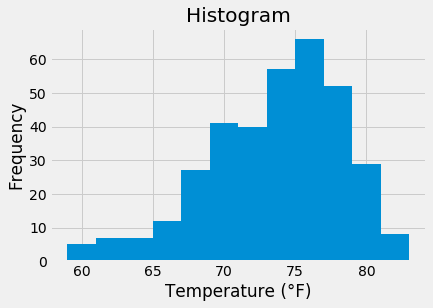

In [128]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram with 12 bins

# query
hist_result = session.query(*sel_measure).\
    filter(Measurement.date >= date1, 
           Measurement.date <= date2).\
    filter(Measurement.station == station_most_active).all()

# pandas df
hist_df = pd.DataFrame(hist_result, columns = ['id', 'station', 'date', 'prcp', 'tobs'])

# histogram with 12 bins
hist_df.hist('tobs', bins = 12)
plt.title('Histogram')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')

plt.show()

In [129]:
# join Measurement and Station tables

sel_join = [Measurement.id,
       Measurement.station,
       Measurement.date,
       Measurement.prcp,
       Measurement.tobs,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation]

result_join = session.query(*sel_join).filter(Measurement.station == Station.station).all()

# pandas df
join_df = pd.DataFrame(result_join, columns = ['id', 'station', 
                                               'date', 'prcp', 'tobs',
                                               'name', 'latitude', 'longitude', 'elevation'])

## Bonus Challenge Assignment

In [111]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
